<a href="https://colab.research.google.com/github/1337Rinz/AI_ML/blob/main/BD_Object_Detection_on_Webcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**YOLOv4 Object Detection on Webcam In Google Colab**

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

#text ▶ đoạn code trên import những thư viện cần thiết




# Cloning and Setting Up Darknet for YOLOv4
We will be using the famous AlexeyAB's darknet repository in this tutorial to perform YOLOv4 detections.

In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15514, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 15514 (delta 1), reused 7 (delta 1), pack-reused 15502
Receiving objects: 100% (15514/15514), 14.19 MiB | 25.49 MiB/s, done.
Resolving deltas: 100% (10404/10404), done.


#text ▶ đoạn code trên clone source code "darknet" từ git


In [ ]:
# change makefile to have GPU, OPENCV and LIBSO enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/darknet


#text ▶  thực hiện cấu hình Darknet để tận dụng GPU, hỗ trợ thư viện OpenCV và CUDNN, và biên dịch thành thư viện động (shared library) khi cần thiết.



In [ ]:
# make darknet (builds darknet so that you can then use the darknet.py file and have its dependencies)
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
  946 |                 float rgb[3];
      |                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
 1147 |            

#text ▶  Dòng mã !make được sử dụng để biên dịch (build) mã nguồn của Darknet từ các tệp và mã nguồn có sẵn trong thư mục "darknet." Quá trình biên dịch này tạo ra các tệp thực thi (executables) và thư viện cần thiết để chạy Darknet và sử dụng các chức năng của nó, bao gồm tệp darknet.py và các phụ thuộc liên quan.



In [ ]:
# get bthe scaled yolov4 weights file that is pre-trained to detect 80 classes (objects) from shared google drive
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq" -O yolov4-csp.weights && rm -rf /tmp/cookies.txt

--2023-03-07 12:38:55--  https://docs.google.com/uc?export=download&confirm=t&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq
Resolving docs.google.com (docs.google.com)... 172.253.62.100, 172.253.62.139, 172.253.62.101, ...
Connecting to docs.google.com (docs.google.com)|172.253.62.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ai2rtjc11si0jfpo4qnv52p9dejvoqmu/1678192725000/17800843676226924807/*/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download&uuid=857be7ad-c19d-4bb1-ab94-573313d68765 [following]
--2023-03-07 12:38:55--  https://doc-14-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ai2rtjc11si0jfpo4qnv52p9dejvoqmu/1678192725000/17800843676226924807/*/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download&uuid=857be7ad-c19d-4bb1-ab94-573313d68765
Resolving doc-14-84-docs.googleusercontent.com (doc-14-84-docs.googleusercontent.com)... 172.253.62.132, 

#text ▶ Sau khi dòng mã được thực hiện, bạn sẽ có tệp yolov4-csp.weights chứa trọng số của mô hình YOLOv4-CSP đã được tiền huấn luyện để nhận dạng 80 lớp đối tượng khác nhau.






## Darknet for Python
In order to utilize YOLOv4 with Python code we will use some of the pre-built functions found within darknet.py by importing the functions into our workstation. Feel free to checkout the darknet.py file to see the function definitions in detail!

In [ ]:
# import darknet functions to perform object detections
from darknet import *
# load in our YOLOv4 architecture network
network, class_names, class_colors = load_network("cfg/yolov4-csp.cfg", "cfg/coco.data", "yolov4-csp.weights")
width = network_width(network)
height = network_height(network)

# darknet helper function to run detection on image
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

#text ▶
from darknet import *: Dòng mã này import các hàm và lớp cần thiết từ tệp darknet.py để thực hiện việc nhận dạng đối tượng.

network, class_names, class_colors = load_network("cfg/yolov4-csp.cfg", "cfg/coco.data", "yolov4-csp.weights"): Dòng này tải mô hình YOLOv4-CSP đã được tiền huấn luyện với 80 lớp đối tượng từ tệp cấu hình "cfg/yolov4-csp.cfg," tệp dữ liệu "cfg/coco.data," và tệp trọng số "yolov4-csp.weights." Kết quả là các biến network (mạng mô hình), class_names (tên các lớp đối tượng), và class_colors (màu cho từng lớp đối tượng).

width = network_width(network): Lấy chiều rộng của hình ảnh mà mô hình yêu cầu cho việc phát hiện.

height = network_height(network): Lấy chiều cao của hình ảnh mà mô hình yêu cầu cho việc phát hiện.

darknet_helper(img, width, height): Hàm darknet_helper được định nghĩa để thực hiện nhận dạng đối tượng trên một hình ảnh cụ thể. Nó nhận vào hình ảnh, chiều rộng và chiều cao đã xác định từ mạng YOLOv4-CSP và thực hiện các bước sau:

Chuyển đổi hình ảnh đầu vào thành định dạng Darknet (chuyển đổi sang RGB và thay đổi kích thước hình ảnh theo đúng chiều rộng và chiều cao của mô hình).
Chạy mô hình để nhận dạng các đối tượng trên hình ảnh đã chuyển đổi.
Trả về kết quả là danh sách các detections (đối tượng được nhận dạng), tỷ lệ chiều rộng và chiều cao ban đầu của hình ảnh để đưa các bounding box về kích thước ban đầu.

## Animal Test Image


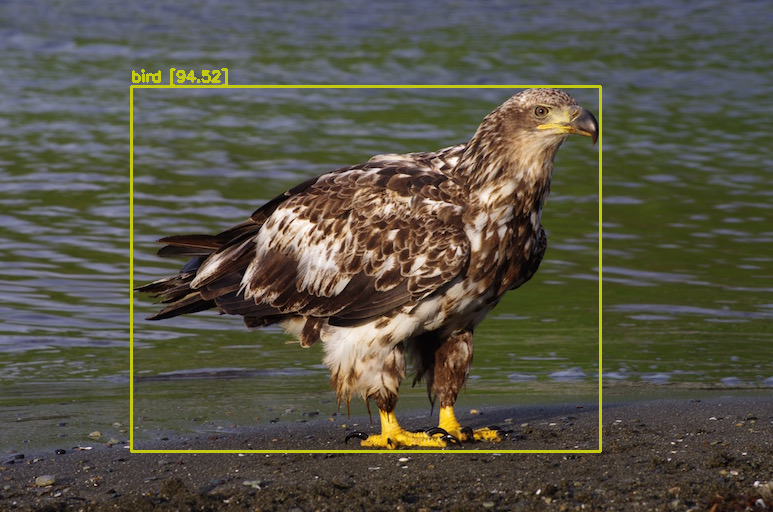

In [ ]:
# run test on person.jpg image that comes with repository
image = cv2.imread("data/eagle.jpg")
detections, width_ratio, height_ratio = darknet_helper(image, width, height)

for label, confidence, bbox in detections:
  left, top, right, bottom = bbox2points(bbox)
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
  cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2)
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    class_colors[label], 2)
cv2_imshow(image)

#text ▶
Đoạn mã trên thực hiện việc chạy kiểm tra (test) mô hình YOLOv4-CSP trên hình ảnh "eagle.jpg" mà có sẵn trong thư mục "data" của dự án. Đầu ra sẽ hiển thị hình ảnh gốc với các bounding box và nhãn đã được vẽ lên hình ảnh để chỉ ra các đối tượng đã được phát hiện.



## Helper Functions
Here are a few helper functions defined that will be used to easily convert between different image types within our later steps.

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

#text ▶
js_to_image(js_reply): Hàm này chuyển đổi một đối tượng JavaScript chứa hình ảnh từ webcam thành hình ảnh OpenCV BGR.

Tham số js_reply: Đối tượng JavaScript chứa hình ảnh được mã hóa dưới dạng chuỗi base64.
Hàm sẽ giải mã chuỗi base64, chuyển đổi nó thành mảng numpy, và sau đó giải mã mảng numpy thành hình ảnh OpenCV BGR.
bbox_to_bytes(bbox_array): Hàm này chuyển đổi hình ảnh bounding box trong OpenCV thành chuỗi byte base64 để chồng lên video stream.

Tham số bbox_array: Mảng numpy (đối tượng pixels) chứa bounding box để chồng lên video stream.
Hàm sẽ chuyển đổi mảng numpy thành hình ảnh PIL và sau đó lưu nó vào một đối tượng io.BytesIO().
Cuối cùng, hàm sẽ trả về chuỗi byte base64 được định dạng để hiển thị bounding box lên video stream.

## Object detection on Wecam Images


In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)

  # call our darknet helper on webcam image
  detections, width_ratio, height_ratio = darknet_helper(img, width, height)

  # loop through detections and draw them on webcam image
  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)
  # save image
  cv2.imwrite(filename, img)

  return filename

#text ▶
Đoạn mã trên định nghĩa một hàm take_photo(filename='photo.jpg', quality=0.8) để chụp ảnh từ webcam và thực hiện nhận dạng đối tượng trên ảnh đã chụp.

js = Javascript(...): Đoạn mã JavaScript được tạo ra để hiển thị giao diện camera trong notebook và cho phép người dùng chụp ảnh.

display(js): Hiển thị giao diện camera và nút "Capture" trong notebook, để người dùng có thể chụp ảnh.

data = eval_js('takePhoto({})'.format(quality)): Thực thi mã JavaScript để chụp ảnh từ webcam. Hàm eval_js sẽ lấy dữ liệu ảnh được trả về từ mã JavaScript.

img = js_to_image(data): Chuyển đổi dữ liệu ảnh từ JavaScript sang hình ảnh OpenCV BGR bằng hàm js_to_image.

detections, width_ratio, height_ratio = darknet_helper(img, width, height): Gọi hàm darknet_helper để thực hiện nhận dạng đối tượng trên hình ảnh img.

Vòng lặp for label, confidence, bbox in detections:: Lặp qua từng detection để lấy các thông tin nhãn, độ tin cậy (confidence), và bounding box (bbox) của đối tượng.

Các dòng trong vòng lặp: Được sử dụng để vẽ các bounding box và nhãn lên hình ảnh gốc img để chỉ ra các đối tượng đã được phát hiện.

cv2.imwrite(filename, img): Lưu hình ảnh gốc đã được chú thích (với bounding box và nhãn) vào tệp có tên filename.

Trả về filename: Hàm trả về tên tệp đã lưu (tên ảnh được chụp) để có thể sử dụng hoặc hiển thị nó sau khi chụp ảnh.

<IPython.core.display.Javascript object>

Saved to photo.jpg


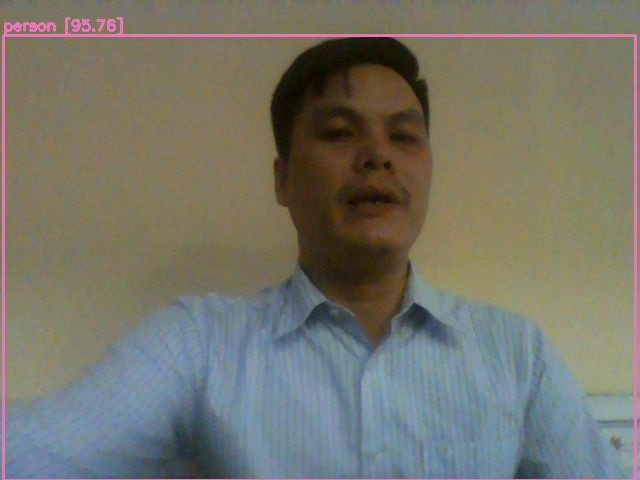

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

#text ▶
Đoạn mã trên thực hiện việc chụp ảnh từ webcam, sau đó hiển thị ảnh đã chụp cùng với bounding box và nhãn đối tượng đã được phát hiện (nếu có). Nếu có lỗi xảy ra trong quá trình chụp ảnh hoặc truy cập webcam, mã sẽ bắt và xử lý ngoại lệ.

filename = take_photo('photo.jpg'): Gọi hàm take_photo để chụp ảnh từ webcam và lưu nó vào tệp có tên "photo.jpg". Tên tệp sẽ được gán cho biến filename.

print('Saved to {}'.format(filename)): In ra thông báo "Saved to ..." với đường dẫn của tệp đã lưu.

display(Image(filename)): Hiển thị ảnh đã chụp (với bounding box và nhãn nếu có) bằng cách tạo một đối tượng Image từ tệp đã lưu và hiển thị nó trong notebook.

except Exception as err:: Đoạn mã trong khối except được thực thi khi có lỗi xảy ra trong khối try.

print(str(err)): In ra thông báo lỗi nếu có lỗi xảy ra trong quá trình chụp ảnh hoặc truy cập webcam. Các lỗi này có thể là do người dùng không có webcam hoặc không cấp quyền truy cập camera.

# Object detection on Webcam Videos
It can run the detections in real-time!

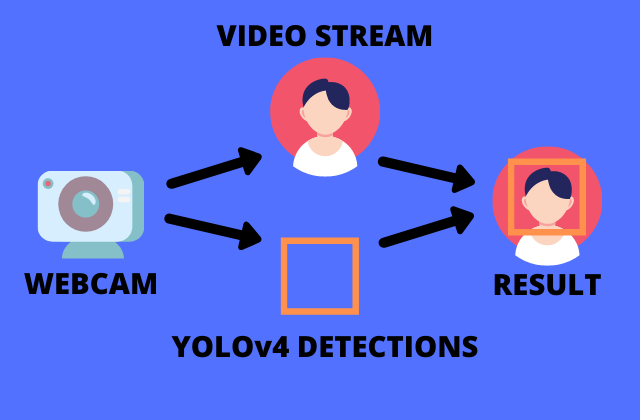


In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

#text ▶ (QUAN TRỌNG)
Đoạn mã trên định nghĩa hai hàm để tạo luồng video trực tiếp từ webcam và nhận dạng đối tượng trên video stream.

video_stream(): Hàm này tạo luồng video trực tiếp từ webcam và hiển thị nó trong notebook. Khi chạy hàm này, người dùng có thể xem video trực tiếp từ camera.

video_frame(label, bbox): Hàm này nhận dữ liệu từ luồng video, bao gồm nhãn (label) và bounding box (bbox) nếu có. Nó trả về thông tin về các bước thực hiện trong quá trình xử lý video stream và dữ liệu ảnh base64 nếu có nhãn và bounding box.

Các hàm JavaScript trong đoạn mã trên được sử dụng để tạo giao diện hiển thị video từ webcam và chụp ảnh từ video stream để thực hiện việc nhận dạng đối tượng trên video stream. Các hàm này hoạt động cùng với các hàm Python đã định nghĩa trước đó để tạo một trải nghiệm trực quan hơn trong việc chụp ảnh và phát hiện đối tượng trên webcam.

## Running on Webcam Video

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # call our darknet helper on video frame
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    # loop through detections and draw them on transparent overlay image
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

#text ▶
Đoạn mã trên bắt đầu chạy luồng video trực tiếp từ webcam bằng cách gọi hàm video_stream(). Sau đó, mã tiếp tục thực hiện việc chụp và phân loại đối tượng trên video stream.

Cụ thể, các bước thực hiện trong vòng lặp while như sau:

js_reply = video_frame(label_html, bbox): Gọi hàm video_frame để nhận dữ liệu từ luồng video, bao gồm nhãn và bounding box nếu có. Biến label_html chứa nhãn để hiển thị trên video, và biến bbox chứa thông tin bounding box để chồng lên video.

if not js_reply: break: Nếu không có dữ liệu trả về từ luồng video (thường là do người dùng đã dừng chạy video), vòng lặp sẽ kết thúc.

frame = js_to_image(js_reply["img"]): Chuyển đổi dữ liệu hình ảnh từ luồng video thành hình ảnh OpenCV BGR bằng hàm js_to_image.

Tạo một hình ảnh bbox_array rỗng với kích thước 480x640x4, trong đó kênh alpha (4) của mỗi điểm ảnh được đặt thành 0.

detections, width_ratio, height_ratio = darknet_helper(frame, width, height): Gọi hàm darknet_helper để thực hiện nhận dạng đối tượng trên hình ảnh frame.

Vòng lặp for label, confidence, bbox in detections:: Lặp qua từng detection để lấy các thông tin nhãn, độ tin cậy (confidence), và bounding box (bbox) của đối tượng.

Các dòng trong vòng lặp: Được sử dụng để vẽ các bounding box và nhãn lên hình ảnh bbox_array, tạo một lớp chồng có độ mờ trên video.

bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255: Đặt giá trị alpha (độ mờ) của mỗi điểm ảnh trong bbox_array dựa vào giá trị của kênh RGB. Nếu kênh RGB của điểm ảnh là màu đen (0), thì alpha sẽ là 0, ngược lại, alpha sẽ là 255, tạo hiệu ứng chồng hình ảnh trong suốt.

bbox_bytes = bbox_to_bytes(bbox_array): Chuyển đổi bbox_array thành chuỗi byte base64 để chồng lên video stream.

bbox = bbox_bytes: Cập nhật biến bbox để có thể chồng lên video frame tiếp theo với bounding box mới.